# 1. Looking at filtered data in comparison with model

We have some pre-downsampled, filtered data from Bobby that no longer has low frequency artifacts.

In [16]:
import sys, os
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import path as pth
from utils import functions
from brain import Brain
from preprocess import permute

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
import numpy as np
import math
from scipy.signal import detrend
from scipy.stats import pearsonr
from scipy.io import loadmat

In [51]:
freq_MEG_mat = '../data/freqMEGdata.mat'

In [53]:
freq_MEG = loadmat(freq_MEG_mat)['freqMEGdata']

In [61]:
patient_1 = data['freqMEGdata'][0][0][0]

In [63]:
patient_1.shape #68 regions, 40 frequencies each.

(68, 40)

We need to put this data in to a dictionary form, and give it the correct ordering. This function will be saved in preprocess/preprocess.py in case it is needed again.

In [64]:
label_filepath = '../atlases/OrderingAlphabetical_68ROIs.txt'

In [65]:
def add_key_to_matdata(label_filepath, data):
    label_file = open(label_filepath, "r")
    lines = label_file.readlines()
    label_file.close()

    #hack for Chang's data -- cleaning up ROIs list format -- can change for other versions
    #of data
    i = 0
    for line in lines:
        index_stop = line.find('.')
        ind_newline = line.find('\n')
        lines[i] = line[0:2].upper()+line[index_stop+1:ind_newline].lower()
        i += 1

    #import the data and apply the list members as keys, resave data in better format

    data_dict = {}
    
    for keys, values in zip(lines, data[:,:]):
        data_dict[keys] = values

    return data_dict

In [66]:
patient_1_dict = add_key_to_matdata(label_filepath, patient_1)

In [68]:
patient_1_dict.keys()

dict_keys(['LHbankssts', 'LHcaudalanteriorcingulate', 'LHcaudalmiddlefrontal', 'LHcuneus', 'LHentorhinal', 'LHfrontalpole', 'LHfusiform', 'LHinferiorparietal', 'LHinferiortemporal', 'LHinsula', 'LHisthmuscingulate', 'LHlateraloccipital', 'LHlateralorbitofrontal', 'LHlingual', 'LHmedialorbitofrontal', 'LHmiddletemporal', 'LHparacentral', 'LHparahippocampal', 'LHparsopercularis', 'LHparsorbitalis', 'LHparstriangularis', 'LHpericalcarine', 'LHpostcentral', 'LHposteriorcingulate', 'LHprecentral', 'LHprecuneus', 'LHrostralanteriorcingulate', 'LHrostralmiddlefrontal', 'LHsuperiorfrontal', 'LHsuperiorparietal', 'LHsuperiortemporal', 'LHsupramarginal', 'LHtemporalpole', 'LHtransversetemporal', 'RHbankssts', 'RHcaudalanteriorcingulate', 'RHcaudalmiddlefrontal', 'RHcuneus', 'RHentorhinal', 'RHfrontalpole', 'RHfusiform', 'RHinferiorparietal', 'RHinferiortemporal', 'RHinsula', 'RHisthmuscingulate', 'RHlateraloccipital', 'RHlateralorbitofrontal', 'RHlingual', 'RHmedialorbitofrontal', 'RHmiddletempo

As an example, don't forget to do the standard re-ordering.

In [70]:
HCP_order = '../atlases/HCP_list.h5'
patient_1_HCP_dict = permute.order_dict(patient_1_dict, HCP_order)

In [71]:
patient_1_HCP_dict.keys()

dict_keys(['LHbankssts', 'LHcaudalanteriorcingulate', 'LHcaudalmiddlefrontal', 'LHcuneus', 'LHentorhinal', 'LHfusiform', 'LHinferiorparietal', 'LHinferiortemporal', 'LHisthmuscingulate', 'LHlateraloccipital', 'LHlateralorbitofrontal', 'LHlingual', 'LHmedialorbitofrontal', 'LHmiddletemporal', 'LHparahippocampal', 'LHparacentral', 'LHparsopercularis', 'LHparsorbitalis', 'LHparstriangularis', 'LHpericalcarine', 'LHpostcentral', 'LHposteriorcingulate', 'LHprecentral', 'LHprecuneus', 'LHrostralanteriorcingulate', 'LHrostralmiddlefrontal', 'LHsuperiorfrontal', 'LHsuperiorparietal', 'LHsuperiortemporal', 'LHsupramarginal', 'LHfrontalpole', 'LHtemporalpole', 'LHtransversetemporal', 'LHinsula', 'RHbankssts', 'RHcaudalanteriorcingulate', 'RHcaudalmiddlefrontal', 'RHcuneus', 'RHentorhinal', 'RHfusiform', 'RHinferiorparietal', 'RHinferiortemporal', 'RHisthmuscingulate', 'RHlateraloccipital', 'RHlateralorbitofrontal', 'RHlingual', 'RHmedialorbitofrontal', 'RHmiddletemporal', 'RHparahippocampal', 'R

Awesome, so we can get things in the right order. Let's take a look at the data.

In [72]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)

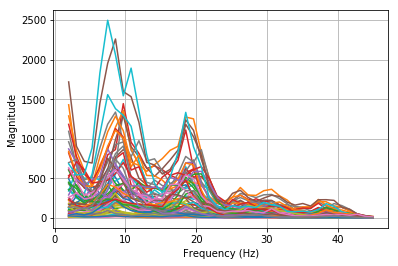

In [73]:
fig = mpl.figure(num=5, figsize = (6,4))
for key in patient_1_HCP_dict.keys():
    mpl.plot(fvec, patient_1_HCP_dict[key])

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')
fig.savefig("Patient1.pdf", bbox_inches='tight')

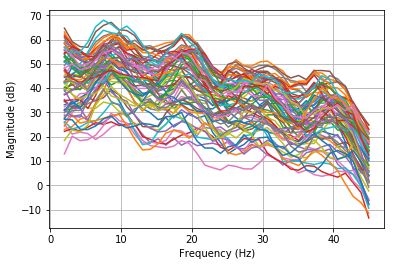

In [74]:
fig1 = mpl.figure(num=5, figsize = (6,4))
for key in patient_1_HCP_dict.keys():
    mpl.plot(fvec,functions.mag2db(patient_1_HCP_dict[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
fig1.savefig("Patient1_dB.pdf", bbox_inches='tight')

## Compare to model

Let's quickly go through the process of obtaining some model data to compare to.

In [75]:
newbrain = Brain.Brain()
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

from forward import runforward as rf
freq_model = rf.run_forward(newbrain, newbrain.ntf_params, fvec)

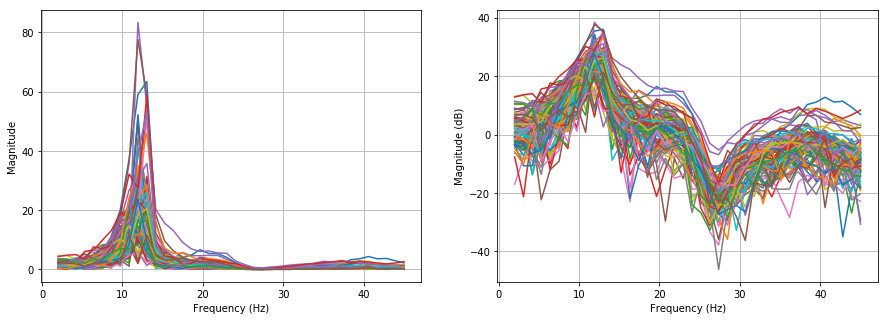

In [76]:
fig2, axes2 = mpl.subplots(1,2, figsize = (15,5))
ax2 = axes2.ravel()
for g in range(len(freq_model)):
    mpl.sca(ax2[0])
    mpl.plot(fvec,np.abs(freq_model[g,:]))
    mpl.sca(ax2[1])
    mpl.plot(fvec,functions.mag2db(np.abs(freq_model[g,:])))


mpl.sca(ax2[0])
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')
mpl.sca(ax2[1])
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
fig2.savefig("Model_defaultparams.pdf", bbox_inches='tight')

## Pearson correlation function

In [77]:
from inverse import cost

In [78]:
error, list_of_errors = cost.pearson(FMEGdownsample, freq_model)

In [79]:
error

1.0987721244783772

In [80]:
len(freq_model[:,0])

86

In [81]:
FMEGdb = {}
freq_modeldb =np.empty((86,40))

for key in FMEGdownsample.keys():
    FMEGdb[key] = functions.mag2db(FMEGdownsample[key])

In [82]:
for g in range(len(freq_model)):
    freq_modeldb[g,:]=functions.mag2db(np.abs(freq_model[g,:]))

In [83]:
error2, list_of_errors2 = cost.pearson(FMEGdb, freq_modeldb)

In [84]:
error2

36.444028021495726

They are expected to be different, as conversion to dB increases the relative importance of the high-frequency tails. Since for now we are focusing on the lower frequencies, let's stick with the linear data. 

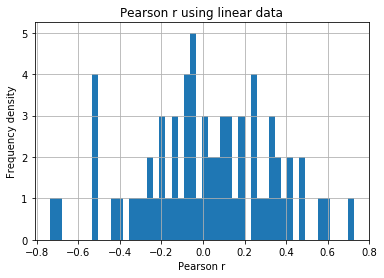

In [85]:
fig4 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors, 50)

mpl.grid(True)
mpl.xlabel('Pearson r')
mpl.ylabel('Frequency density')
mpl.title('Pearson r using linear data')
fig4.savefig("Pearsonr-patient1-lineardata", bbox_inches='tight')

This indicates that a significant number of the pearson r numbers here are negative. Also, for this set of parameters at least, the Pearson r values are distributed around 0, indicating a poor fit generally.

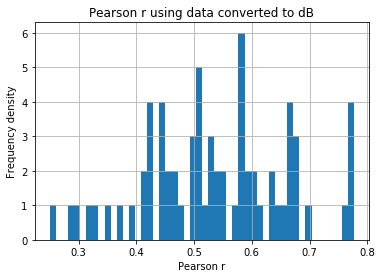

In [86]:
fig5 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors2, 50)

mpl.grid(True)
mpl.xlabel('Pearson r')
mpl.ylabel('Frequency density')
mpl.title('Pearson r using data converted to dB')
fig5.savefig("Pearsonr-patient1-dBdata", bbox_inches='tight')

## Likelihood function

We need to make a likelihood function using the cost function we have (and with the flexibility to change it). Typically when fitting a model, one makes an assumption such as 'the residuals are normally distributed' (which we saw in the MCMC Hammer example). Here we are not dealing with direct residuals, so we need to transform our 'cost function' to something that we can discuss in those terms. 

First, let's look at what happens when we convert to '1-r'.

In [87]:
# error3, list_of_errors3 = cost.pearson_cost_oneminus(FMEGdownsample, freq_model)

In [88]:
fig6 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors3, 50)

mpl.grid(True)
mpl.xlabel('1 - Pearson r')
mpl.ylabel('Frequency density')
mpl.title('1-Pearson r using linear data')
fig6.savefig("Pearsonr_oneminus-patient1-lineardata", bbox_inches='tight')

NameError: name 'list_of_errors3' is not defined

<Figure size 432x288 with 0 Axes>

Now let's try the alternative of e$^{-r}$, using the function 'cost.pearson_cost_exp' from the inverse/cost.py module.

In [32]:
error4, list_of_errors4 = cost.pearson_cost_exp(FMEGdownsample, freq_model)

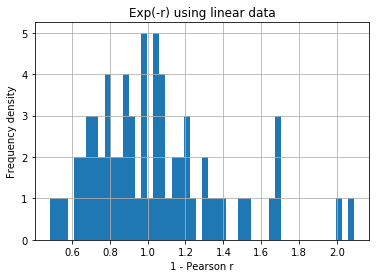

In [33]:
fig7 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors4, 50)

mpl.grid(True)
mpl.xlabel('1 - Pearson r')
mpl.ylabel('Frequency density')
mpl.title('Exp(-r) using linear data')
fig7.savefig("Pearsonr_exp-patient1-lineardata", bbox_inches='tight')

In [34]:
from scipy import stats
m, s = stats.norm.fit(list_of_errors3)
x = np.linspace(0, 2, len(list_of_errors3))

NameError: name 'list_of_errors3' is not defined

In [35]:
pdf_g = 3*stats.norm.pdf(x, m, s) # now get theoretical values in our interval  
mpl.plot(x, pdf_g, label="Norm") # plot it
mpl.hist(list_of_errors3, 50)

mpl.grid(True)
mpl.xlabel('1 - Pearson r')
mpl.ylabel('Frequency density')
mpl.title('Errors using linear data')

NameError: name 'x' is not defined

It seems reasonable to think of this '1-pearsonr correlation' error as being normally distributed around 1.00. The standard deviation found in this particular case is 0.3. Just to check how much things change with a different run of the model, I am going to run it again with a change of parameters.

In [38]:
params ={'tau_e':0.012,'tau_i':0.008,'alpha':1.0,'speed':10.0,'gei':4.0,'gii':3.0,'tauC':0.012}
freq_model = rf.run_forward(newbrain, params, fvec)

In [39]:
error4, list_of_errors4 = cost.pearson_cost_oneminus(FMEGdownsample, freq_model)

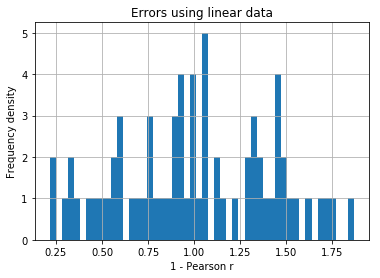

In [40]:
fig8 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors4, 50)

mpl.grid(True)
mpl.xlabel('1 - Pearson r')
mpl.ylabel('Frequency density')
mpl.title('Errors using linear data')
fig8.savefig("1-Pearsonr-patient1-lineardata_NEWPARAMS", bbox_inches='tight')

This looks pretty similar and is in the range of what we expect, although the parameters didn't change much. Let's just try some extreme parameters just in case.

In [41]:
params2 ={'tau_e':0.1,'tau_i':0.1,'alpha':10.0,'speed':20.0,'gei':10.0,'gii':10.0,'tauC':0.1}

freq_model = rf.run_forward(newbrain, params2, fvec)

In [42]:
error5, list_of_errors5 = cost.pearson_cost_oneminus(FMEGdownsample, freq_model)

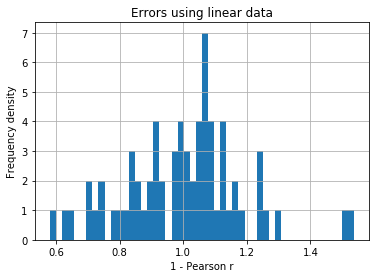

In [43]:
fig9 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors5, 50)

mpl.grid(True)
mpl.xlabel('1 - Pearson r')
mpl.ylabel('Frequency density')
mpl.title('Errors using linear data')
fig9.savefig("1-Pearsonr-patient1-lineardata_CRAZYPARAMS", bbox_inches='tight')

The crazy params have reduced the value of the correlation for a lot of regions, thereby bringing '1-r' in to a tighter distribution around 1. 

HOWEVER, it is really really important to remember what we are trying to achieve here: we want to maximise pearson r, ideally, so we need a distribution that does that. That would be minimising this 1-pearsonr, for instance. Unfortunately, pearson r values are normally distributed around 0, not 1.  It is potentially dodgy to claim that this will represent a sensible likelihood function.

But, for the sake of simplicity now, let's just define a really basic likelihood distribution where we say we assume '1-r' is normally distributed around 0, with s.d. of 1, and that we aim to maximimse that. It may very well not be the correct distribution, but I am doing it to get on with setting up code, so we can change it later. 

We define a likelihood function where we find errors for all regions for the set of parameters at hand, and calculate the overall -log(likelihood) which is a quantity to be minimised. (See the MCMC Hammer example).

In [44]:
def ln_likelihood_pearson(theta, brain, fvec, FMEGdata):
    
    #first, run the ntf model for this setting of parameters
    freq_model = rf.run_forward(brain, theta, fvec)
    
    #now calculate the pearson r based error
    errors, list_errors = cost.pearson_cost_oneminus(FMEGdata, freq_model)
    
    list_errors = np.asarray(list_errors)
    
    #calculate the total negative lnlikelihood based on the errors of the pearson cost function
    return -0.5*(np.sum(list_errors**2))

In [46]:
triallikelihood = ln_likelihood_pearson(params2, newbrain, fvec, FMEGdownsample)

Let's run that for a single sweep of tau_e

In [47]:
taue_run = np.linspace(0.001, 2, 100)

In [48]:
params ={'tau_e':0.1,'tau_i':0.1,'alpha':10.0,'speed':20.0,'gei':10.0,'gii':10.0,'tauC':0.1}
trials = np.empty(len(taue_run))
for i in range(len(taue_run)):
    params['tau_e'] = taue_run[i]
    trials[i] = ln_likelihood_pearson(params, newbrain, fvec, FMEGdownsample)

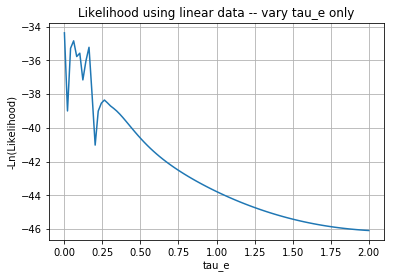

In [49]:
fig10 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(taue_run, trials)

mpl.grid(True)
mpl.xlabel('tau_e')
mpl.ylabel('-Ln(Likelihood)')
mpl.title('Likelihood using linear data -- vary tau_e only')
fig10.savefig("Likelihood_tauevaryonly", bbox_inches='tight')

## Alternative approach to cost function

In typical applications of MCMC we actually just use a direct residual, but here the scale of the model and data are very different. We can try just using an additional free 'scale parameter'. This can be a simple multiplicative constant in addition to the existing seven parameters. However, since all the regions produce slightly different strength signals, in reality it should be a different parameter for each brain region. 

For now, let's include a likelihood function that just makes use of a single scale. To get intuition for what that should be, we look at the relative sizes of the linear data and model.

In [55]:
freq_model = rf.run_forward(newbrain, newbrain.ntf_params, fvec)
scalevalues = []
g = 0
for key in FMEGdownsample.keys():
    modregion = freq_model[g,:]
    region = FMEGdownsample[key]
    region = [float(x) for x in region]
    modregion = [float(x) for x in modregion]
    modregionmax = max(modregion)
    datamax = max(region)
    scalevalues.append(datamax/modregionmax)
    g += 1

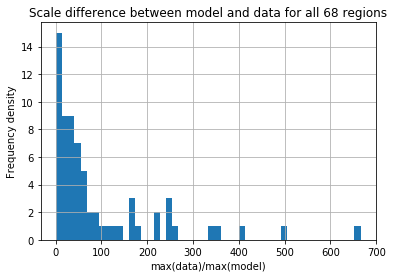

In [59]:
fig11 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(scalevalues, 50)

mpl.grid(True)
mpl.xlabel('max(data)/max(model)')
mpl.ylabel('Frequency density')
mpl.title('Scale difference between model and data for all 68 regions')
fig11.savefig("Scaledifferences", bbox_inches='tight')

The scaling factor for different regions needs to be very different, according to this, which makes using a simple linear constant challenging. Technically, this would imply using a whole set of 68 additional parameters...